# Grating Coupler

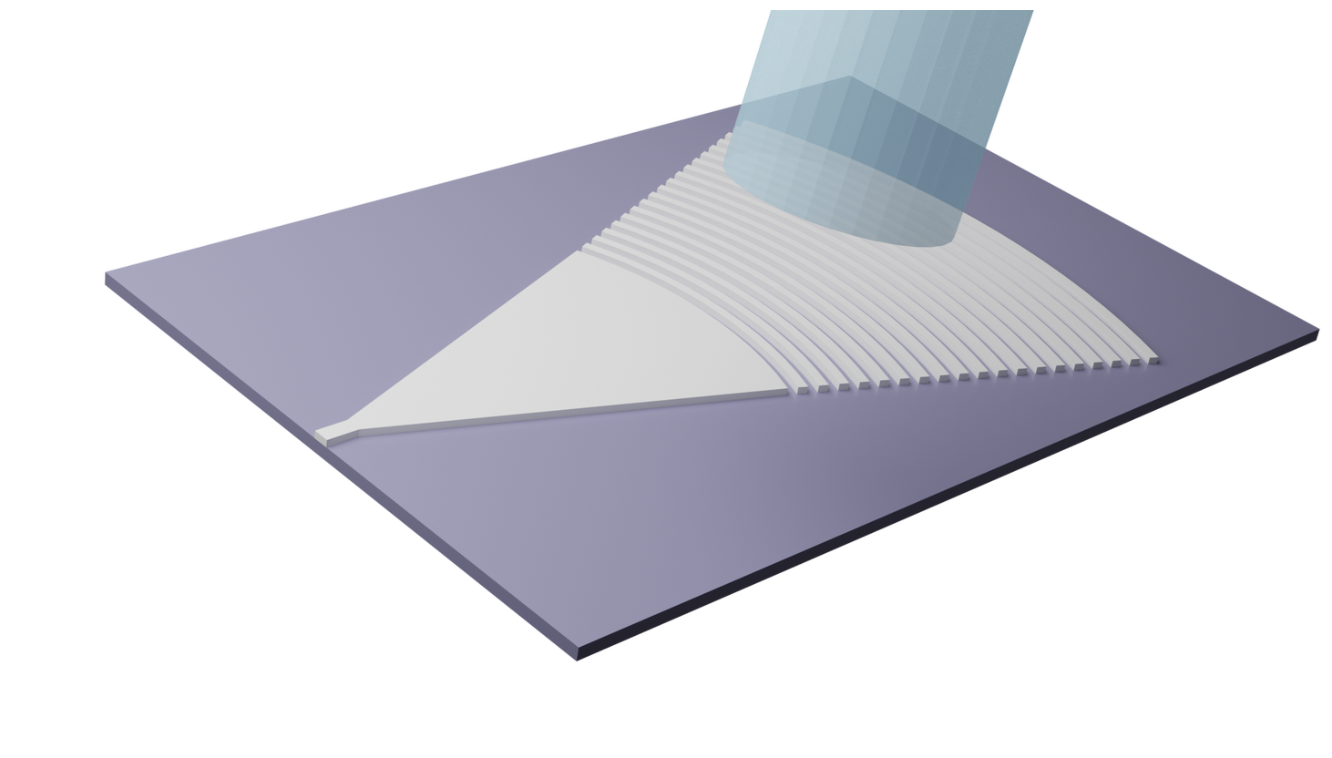

This example shows how to use the focused grating [stencil](../stencil.rst) to create a grating coupler component equivalent to the one demonstrated in \[1].
We use a [Gaussian port](../_autosummary/photonforge.GaussianPort.rst) to model the fiber input and a [Tidy3D model](../guides/Tidy3D_Model.ipynb) to evaluate the grating S parameters.

**References**

1. Frederik Van Laere, Tom Claes, Jonathan Schrauwen, Stijn Scheerlinck, Wim Bogaerts, Dirk Taillaert, Liam O'Faolain, Dries Van Thourhout, Roel Baets, "Compact Focusing Grating Couplers for Silicon-on-Insulator Integrated Circuits," in *IEEE Photonics Technology Letters*, vol. **19**, no. 23, pp. 1919-1921, Dec.1, 2007, doi: [10.1109/LPT.2007.908762](https://doi.org/10.1109/LPT.2007.908762)

In [1]:
import numpy as np
import tidy3d as td
import photonforge as pf
from matplotlib import pyplot as plt

The technology used in the reference work \[1] is similar to the default available as PhotonForge's [basic technology](../_autosummary/photonforge.basic_technology.rst), with 2 important differences: the slab thickness and the absence of the top cladding.

## Technology Setup

Changing the slab thickness to emulate the 70 nm etch depth is a matter of setting ``slab_thickness`` to 150 nm:

In [2]:
tech = pf.basic_technology(slab_thickness=0.15)
pf.config.default_technology = tech

Unfortunately, there is no argument to remove the top cladding, because the basic technology sets top and bottom media to the background medium, and we cannot set the top cladding thickness to 0 because it is used to set the port dimensions.

A better option is to add an new [extrusion specification](../_autosummary/photonforge.ExtrusionSpec.rst) to the technology that creates a extra air volume above the substrate level with infinite thickness.
That can be accomplished with the [insert_extrusion_spec](../_autosummary/photonforge.Technology.rst#photonforge.Technology.insert_extrusion_spec) function:

In [3]:
# An empty mask covers the whole device bounds
air_extrusion = pf.ExtrusionSpec(pf.MaskSpec(), td.Medium(permittivity=1.0), limits=(0, pf.Z_INF))

# Insert air volume first, so that all core extrusions override the air clad
tech.insert_extrusion_spec(0, air_extrusion)
tech.extrusion_specs

[ExtrusionSpec(mask_spec=MaskSpec(operand0=[], operand1=[], operation='+'), medium=Medium(attrs={}, name=None, frequency_range=None, allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='Medium', permittivity=1.0, conductivity=0.0), limits=(0, 2e+07), sidewall_angle=0),
 ExtrusionSpec(mask_spec=MaskSpec((2, 0)), medium=PoleResidue(attrs={}, name=None, frequency_range=(21413747041496.2, 249827048817455.7), allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='PoleResidue', eps_inf=1.0, poles=((6241549589084091j, -3.3254308736142404e+16j),)), limits=(0, 0.22), sidewall_angle=0),
 ExtrusionSpec(mask_spec=MaskSpec((3, 0)), medium=PoleResidue(attrs={}, name=None, frequency_range=(21413747041496.2, 249827048817455.7), allow_gain=False, nonlinear_spec=None, modulation_spec=None, heat_spec=None, type='PoleResidue', eps_inf=1.0, poles=((6241549589084091j, -3.3254308736142404e+16j),)), limits=(0, 0.15), sidewall_angle=0),
 ExtrusionSpec(m

Now we can design the component based on the technology we created, using its layers and port specifications, and the [focused grating](../_autosummary/photonforge.stencil.focused_grating.rst) stencil.
We will create is as a parametric component with a few parameters we can latter use for fine-tuning or optimizing for other wavelengths.

In [4]:
@pf.parametric_component
def grating_coupler(
    *,
    period,
    focal_length,
    length,
    angle,
    fiber_angle,
    fiber_translation=0,
    fill_factor=0.5,
):
    n_env = 1.0  # Top cladding refractive index
    waist_radius = 6.0
    gaussian_port_height = 0.5  # Make sure the Gaussian port above the core
    input_length = 1.0  # Small waveguide section for the taper mode to accommodate

    # Get the core width for the strip waveguide port
    port_spec = tech.ports["Strip"]
    layer = tech.layers["WG_CORE"].layer
    input_width = sum(w for w, _, l in port_spec.path_profiles if l == layer)

    # Define the port input vector based on the fiber angle
    sin_angle = np.sin(fiber_angle / 180 * np.pi)
    cos_angle = np.cos(fiber_angle / 180 * np.pi)
    input_vector = (-sin_angle, 0, -cos_angle)

    # Use automatic naming from the parametric_component decorator
    c = pf.Component()

    # Add the waveguide section
    for layer, path in port_spec.get_paths((0, 0)):
        c.add(layer, path.segment((input_length, 0)))

    grating = pf.stencil.focused_grating(
        1.55,
        period,
        n_env * sin_angle,
        focal_length=focal_length,
        length=length,
        angle=angle,
        fill_factor=fill_factor,
        input_width=input_width,
    )
    # Move the grating structures to make room for the waveguide section
    for structure in grating:
        structure.translate((input_length, 0))

    c.add("WG_CORE", *grating)

    # Add the 150 nm slab around the whole grating
    grating_slab = pf.envelope(grating[1:], period)
    c.add("SLAB", grating_slab)

    # Add a cladding polygon around the component, but trimmed at the waveguide port
    clad_region = pf.envelope(grating, 1.5, trim_x_min=True)
    c.add("WG_CLAD", clad_region)

    c.add_port(pf.Port((0, 0), 0, port_spec))

    gaussian_port_center = (
        np.array((focal_length + 0.5 * length + fiber_translation, 0, 0))
        + input_vector / input_vector[2] * gaussian_port_height
    )
    c.add_port(
        pf.GaussianPort(
            gaussian_port_center,
            input_vector,
            waist_radius,
            polarization_angle=90,
            field_tolerance=1e-2,
        )
    )

    # This is a large model, so we probably want to minimize the simulation size wherever possible.
    # We decrease the refinement from 20 (default) to 15, which has minimal impact on the final
    # result. We can increase it back for later for verification, if needed. We also specify the
    # symmetry in the y axis (assuming TE mode) to halve the computation domain.
    grid_spec = td.GridSpec.auto(wavelength=1.55, min_steps_per_wvl=15)
    c.add_model(
        pf.Tidy3DModel(symmetry=(0, -1, 0), grid_spec=grid_spec),
        "Tidy3D",
    )

    return c

We use the parameters from the reference work to create the component.

In [5]:
grating = grating_coupler(focal_length=12.5, length=15.5, period=0.63, angle=45, fiber_angle=10)
grating

Once we define the simulation wavelengths, we can get the simulations for the grating to make sure our port placement and setup is correct.

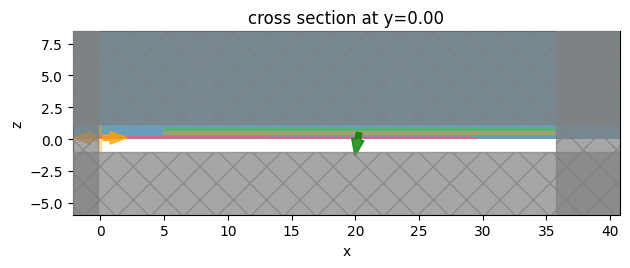

In [6]:
wavelengths = np.linspace(1.5, 1.6, 21)
sims = grating.models["Tidy3D"].get_simulations(grating, pf.C_0 / wavelengths)
_ = sims["P1@0"].plot(y=0)

Now we can compute the [S parameters](../guides/S_Parameters.ipynb) as usual:

Starting...
Loading cached simulation from .tidy3d/pf_cache/I3Q/fdtd_info-XO42Q3UK6PRIDWURZ6VSL7ASWOQKXNRFYH7TQV4K3G653EFXLS6A.json.


Loading cached simulation from .tidy3d/pf_cache/I3Q/fdtd_info-N5RMKY6DD3VMYTIT647ET2BFIVB6LBI3SDBDOJPGYYUHOJUINIXA.json.


Loading cached simulation from .tidy3d/pf_cache/I3Q/ms_info-YVJV4OBWJWQB46IZFZAUXQCCMEV3NAXWPCUQEVP5T37KNJKDNDDA.json.
Progress: 100% 


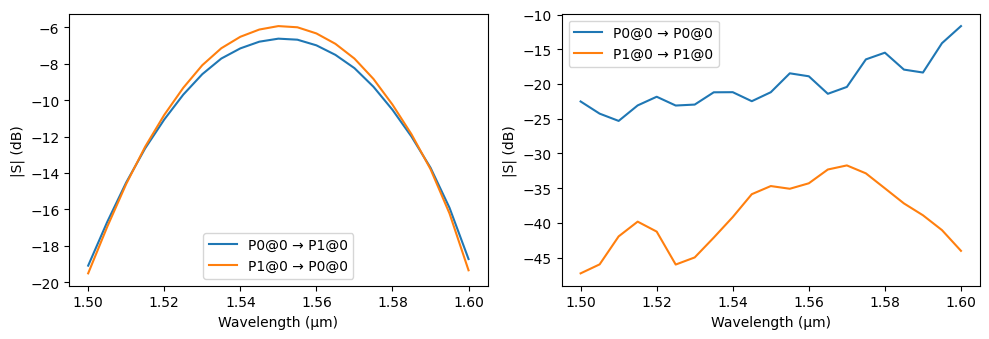

In [7]:
s_matrix = grating.s_matrix(pf.C_0 / wavelengths)
_ = pf.plot_s_matrix(s_matrix, y="dB")

## Fiber Adjustment

We see that the wavelength of the efficiency peak is very close to that of the experimental results, but the loss is a little higher.
The experiments show values between -5 dB and -6 dB per grating.
That extra penalty can be removed by adjusting the Gaussian port position over the grating, which is one of the experimental adjustments done to optimize the transmission that is difficult to measure.

A simple parametric sweep can be used here to improve the result, which reaches the desired level above -6 dB.
Note that we're only running the simulations we really require for the transmission by explicitly setting the ports and modes we want as input for the [Tidy3D model](../guides/Tidy3D_Model.ipynb).

Starting...


Progress: 100% 


Starting...


Progress: 100% 


Starting...


Progress: 100% 


Starting...


Progress: 100% 


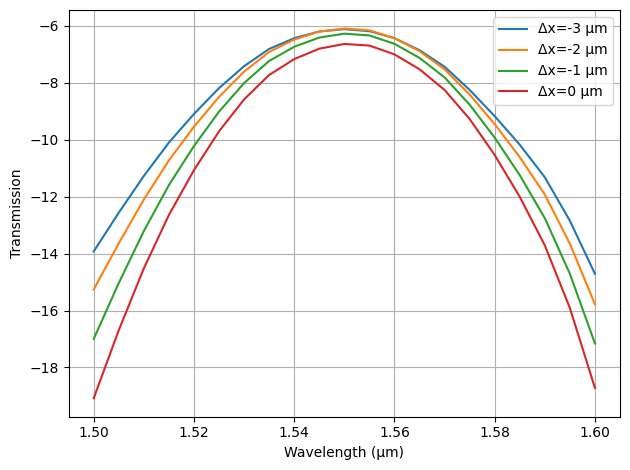

In [8]:
_, ax = plt.subplots(1, 1, tight_layout=True)

for dx in range(-3, 1):
    grating.update(fiber_translation=dx)
    # The model is updated after the component because the component update re-creates the model
    grating.models["Tidy3D"].update(verbose=False)
    s = grating.s_matrix(pf.C_0 / wavelengths, model_kwargs={"inputs": ["P0@0"]})
    ax.plot(pf.C_0 / s.frequencies, 20 * np.log10(np.abs(s["P0@0", "P1@0"])), label=f"Δx={dx} μm")

ax.set(xlabel="Wavelength (μm)", ylabel="Transmission")
ax.legend()
ax.grid(True)